# 1. EDA

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from ydata_profiling import ProfileReport
from scipy import stats
from scipy import special

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 500)

df_train = pd.read_csv("train_test_submission/train.csv")
df_train_Id = df_train["Id"]
df_train = df_train.drop("Id", axis=1)

df_test = pd.read_csv("train_test_submission/test.csv")
df_test_Id = df_test["Id"]
df_test = df_test.drop("Id", axis=1)

print(f"df_train.shape: {df_train.shape}")
display(df_train.head(5))
print(f"df_train.shape: {df_test.shape}")
display(df_test.head(5))

df_train.shape: (1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


df_train.shape: (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [2]:
print("-" * 10, "df_train.info()", "-" * 10)
print(df_train.info())

print("-" * 10, "df_test.info()", "-" * 10)
print(df_test.info())

---------- df_train.info() ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond   

In [3]:
# # ydata_profilingを使う場合。時間かかるので注意

# if not os.path.exists("ydata_profiling"):
#     os.makedirs("ydata_profiling")

# profile = ProfileReport(df_train, minimal=True)
# profile.to_file("ydata_profiling/kaggle_houseprices_minimal.html")

# # profile = ProfileReport(df_train, minimal=False)
# # profile.to_file("ydata_profiling/kaggle_houseprices.html")

---------- df_train["SalePrice"].describe() ----------
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


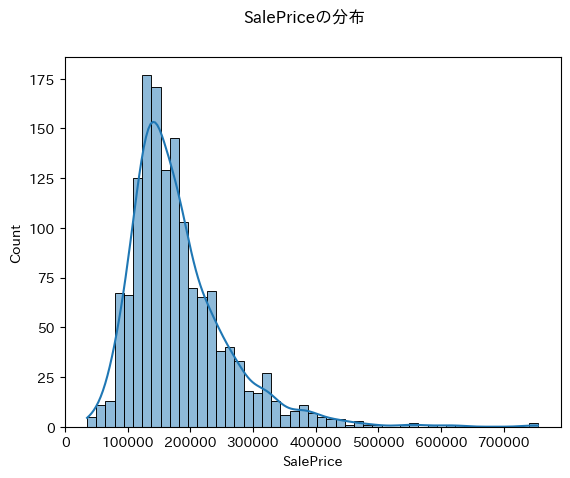

In [4]:
print("-" * 10, 'df_train["SalePrice"].describe()', "-" * 10)
print(df_train["SalePrice"].describe())

# SalePriceの分布
sns.histplot(df_train["SalePrice"], kde=True)
plt.suptitle("SalePriceの分布")
plt.show()

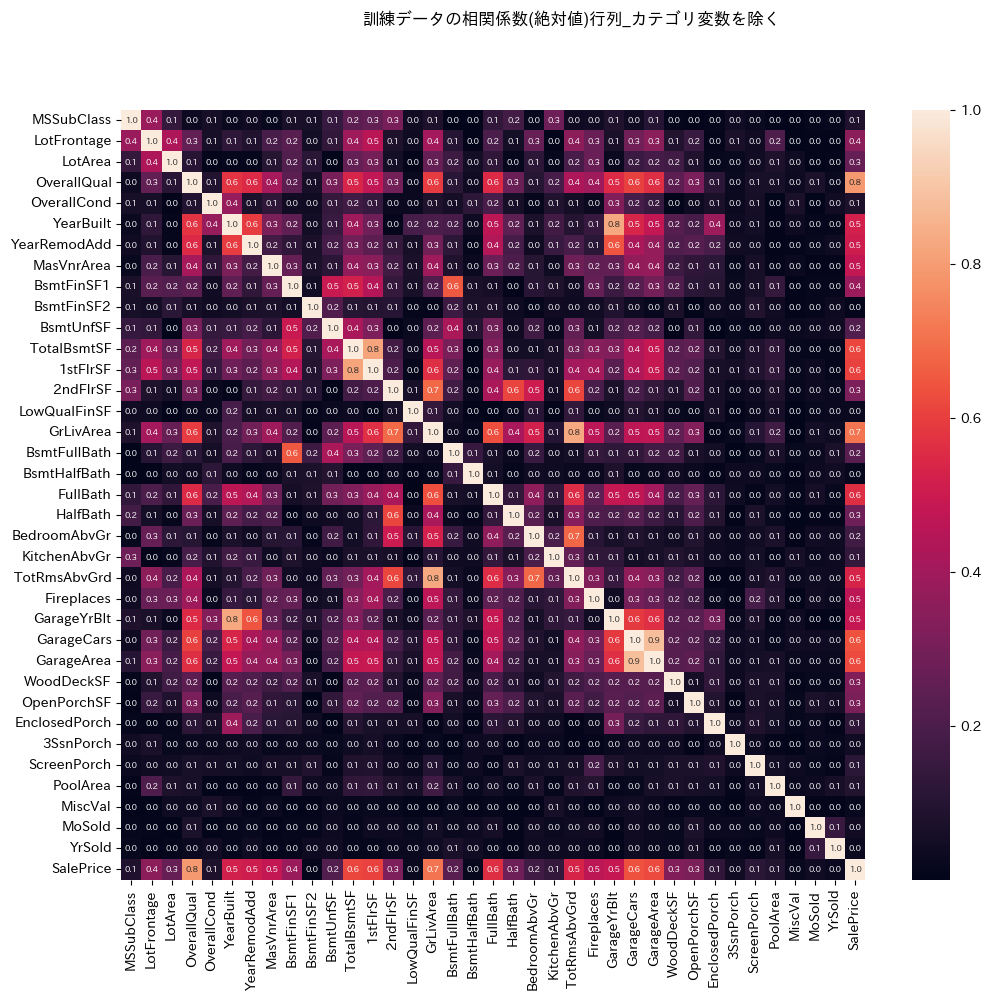

In [5]:
corr_matrix = df_train.corr(numeric_only=True)
"""
    訓練データdf_trainの相関係数行列
    corr_matrix = df_train.corr(numeric_only=True)
"""

plt.figure(figsize=(12, 10))
sns.heatmap(abs(corr_matrix), annot=True, fmt=".1f", annot_kws={"fontsize": 6})

plt.suptitle("訓練データの相関係数(絶対値)行列_カテゴリ変数を除く")
plt.show()

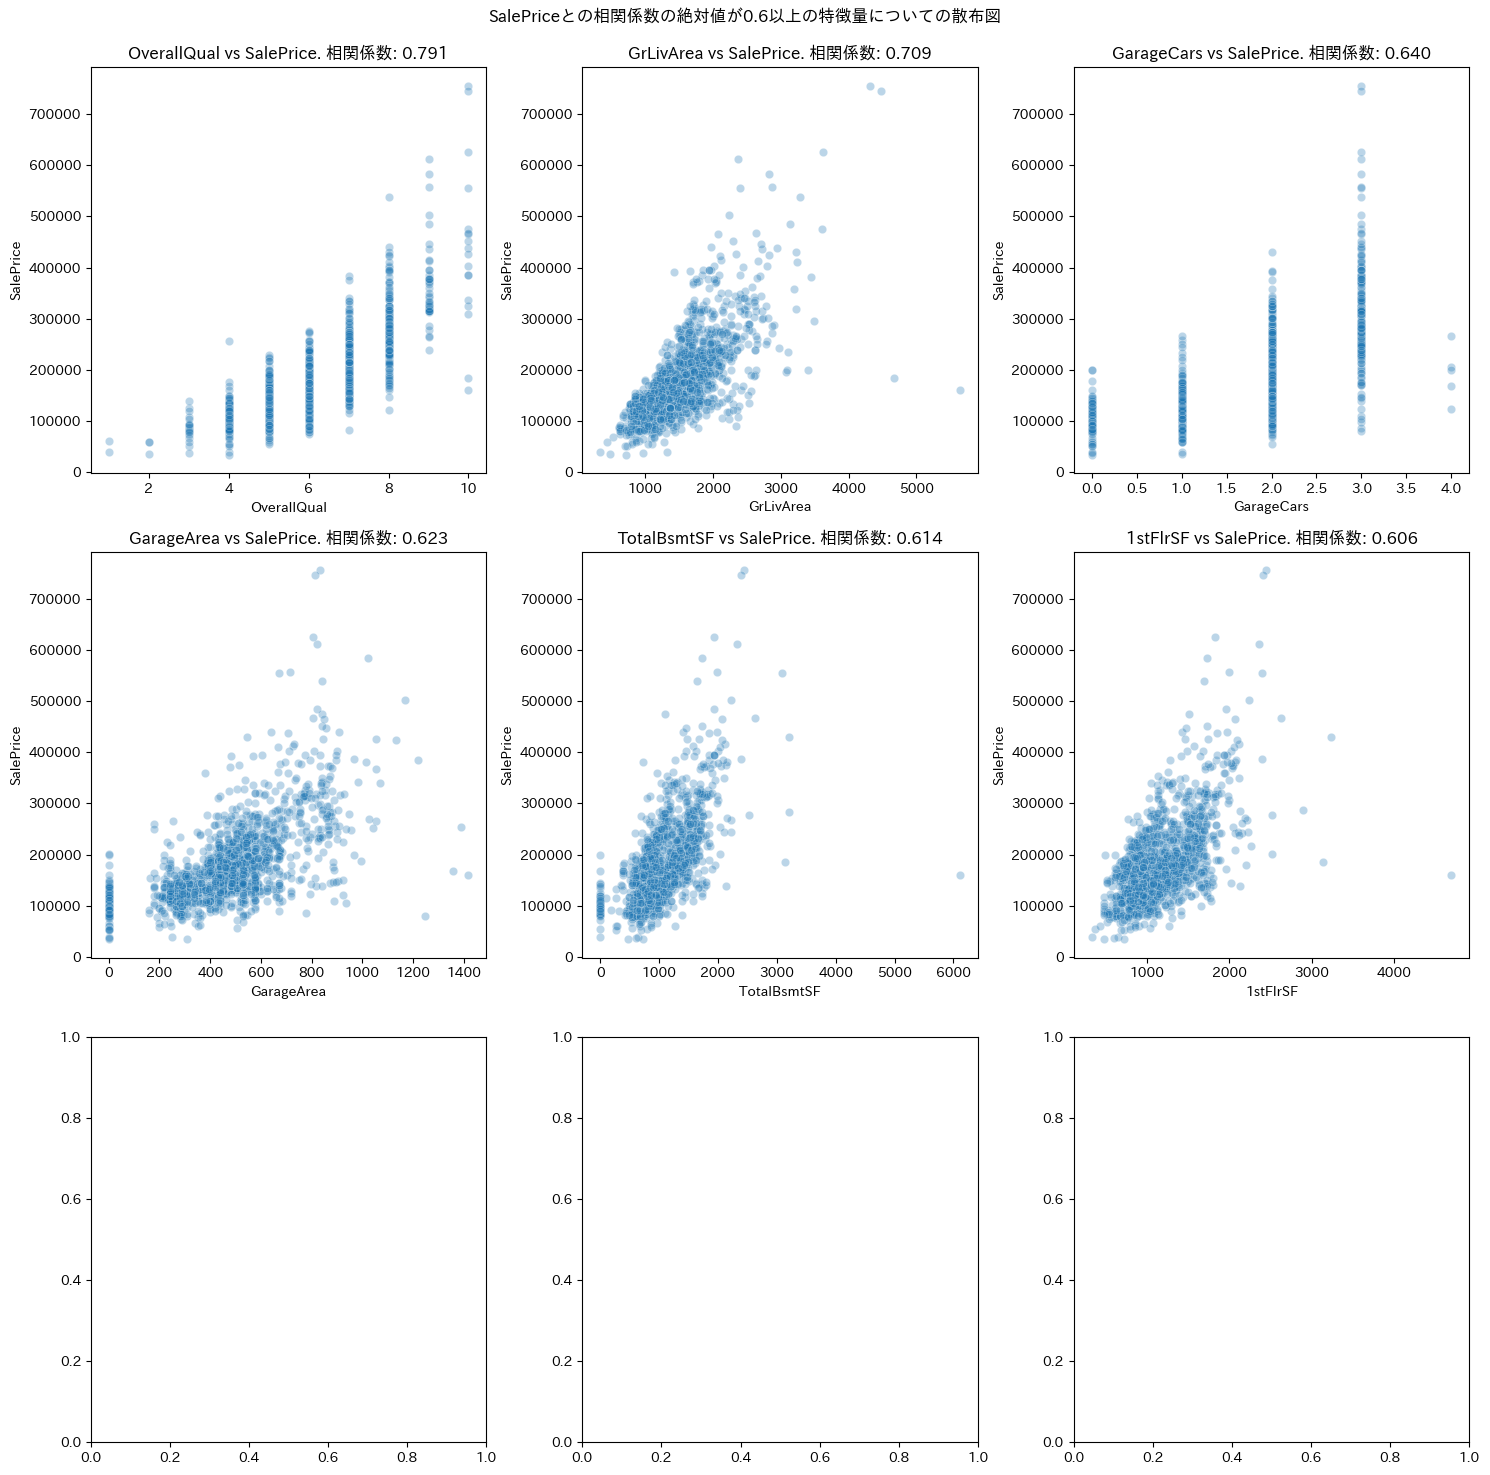

In [6]:
threshold = 0.6
high_corr_cols = (
    corr_matrix["SalePrice"][abs(corr_matrix["SalePrice"]) >= threshold]
    .sort_values(ascending=False)
    .index
).drop("SalePrice")

# プロットのサイズを指定 (行数と列数は自由に調整可能)
num_cols = len(high_corr_cols)
fig, axes = plt.subplots(
    nrows=(num_cols // 3 + 1), ncols=3, figsize=(15, 5 * (num_cols // 3 + 1))
)

# high_corr_colsにある特徴量ごとに散布図を描く
for ax, col in zip(axes.flatten(), high_corr_cols):
    sns.scatterplot(x=df_train[col], y=df_train["SalePrice"], alpha=0.3, ax=ax)
    ax.set_title(f"{col} vs SalePrice. 相関係数: {corr_matrix["SalePrice"][col]:.3f}")

# グラフのレイアウトを自動調整
plt.suptitle(
    f"SalePriceとの相関係数の絶対値が{threshold}以上の特徴量についての散布図\n"
)
plt.tight_layout()
plt.show()

# 外れ値が同じデータを指しているのかどうかをパパッと確認したいが…このままだと出来ない
# plotlyとかいうインタラクティブにグラフを描けるライブラリを使うと良いかも？
# とりあえず、もう一度スターター？見るか

# 2. 前処理

In [7]:
# 特徴量エンジニアリング
# 新しい特徴量（'TotalSF'：'TotalBsmtSF'、'1stFlrSF'、'2ndFlrSF'を合計したもの。）の作成

datasets = [df_train, df_test]
for i in range(len(datasets)):
    datasets[i]["TotalSF"] = (
        datasets[i]["TotalBsmtSF"] + datasets[i]["1stFlrSF"] + datasets[i]["2ndFlrSF"]
    )

In [8]:
# lightGBMに突っ込むためには数値型(またはbool型)である必要があるので、object型のデータをlabel encodingで処理する
# https://qiita.com/Hyperion13fleet/items/afa49a84bd5db65ffc31　こっちのほうが便利？

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, plot_tree
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_percentage_error as mape

# object型のデータが入っている列を抽出
object_columns = df_train.select_dtypes(include="object").columns
df_train_pre_encoding = df_train.copy()
df_test_pre_encoding = df_test.copy()

# ラベルエンコーディング
oe = OrdinalEncoder()
df_train[object_columns] = oe.fit_transform(df_train[object_columns])
df_test[object_columns] = oe.fit_transform(df_test[object_columns])

print("df_train_pre_encoding")
display(df_train_pre_encoding.head(3))
print("df_train")
display(df_train.head(3))

df_train_pre_encoding


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,2566
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,2524
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,2706


df_train


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF
0,60,3.0,65.0,8450,1.0,NaN,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7,5,2003,2003,1.0,1.0,12.0,13.0,1.0,196.0,2.0,4.0,2.0,2.0,3.0,3.0,2.0,706,5.0,0,150,856,1.0,0.0,1.0,4.0,856,854,0,1710,1,0,2,1,3,1,2.0,8,6.0,0,NaN,1.0,2003.0,1.0,2,548,4.0,4.0,2.0,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,8.0,4.0,208500,2566
1,20,3.0,80.0,9600,1.0,NaN,3.0,3.0,0.0,2.0,0.0,24.0,1.0,2.0,0.0,2.0,6,8,1976,1976,1.0,1.0,8.0,8.0,NaN,0.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,978,5.0,0,284,1262,1.0,0.0,1.0,4.0,1262,0,0,1262,0,1,2,0,3,1,3.0,6,6.0,1,4.0,1.0,1976.0,1.0,2,460,4.0,4.0,2.0,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,8.0,4.0,181500,2524
2,60,3.0,68.0,11250,1.0,NaN,0.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7,5,2001,2002,1.0,1.0,12.0,13.0,1.0,162.0,2.0,4.0,2.0,2.0,3.0,2.0,2.0,486,5.0,0,434,920,1.0,0.0,1.0,4.0,920,866,0,1786,1,0,2,1,3,1,2.0,6,6.0,1,4.0,1.0,2001.0,1.0,2,608,4.0,4.0,2.0,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,8.0,4.0,223500,2706


In [9]:
# # ラベルエンコーディング後に改めて相関係数行列を表示してみる
# corr_matrix = df_train.corr(numeric_only=True)

# plt.figure(figsize=(24, 20))
# sns.heatmap(abs(corr_matrix), annot=True, fmt=".1f", annot_kws={"fontsize": 6})

# カテゴリ変数を含めて相関をみたいのなら、カテゴリ変数の順位関係を考慮したラベル付けをしておかねばなるまい
# しかし現状はそうはなっていない…
# plt.suptitle("訓練データの相関係数(絶対値)行列_ラベルエンコーディング後")
# plt.show()

In [10]:
X = df_train.drop(["SalePrice"], axis=1)
y = df_train["SalePrice"]

# クロスバリデーション
kf = KFold(n_splits=4, shuffle=True, random_state=42)

scores = []
# params = {}
params = {"max_depth": 19, "learning_rate": 0.1}
# パラメータチューニングにはoptunaというのを使うと良いらしい
# https://qiita.com/tetsuro731/items/a19a85fd296d4b87c367
# https://qiita.com/tetsuro731/items/76434194bab336a97172

for fold_idx, (tr_idx, va_idx) in enumerate(kf.split(X)):
    print(f"分割 {fold_idx + 1} / {kf.n_splits}")

    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    model = LGBMRegressor(**params)
    # GBDTのパラメータについて。https://knknkn.hatenablog.com/entry/2021/06/29/125226
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)

    score = rmse(np.log10(y_pred), np.log10(y_va))
    print(f"スコア(rmse(np.log10(y_pred), np.log10(y_va)): {score}")
    mape_ = mape(y_pred, y_va) * 100
    print(f"MAPE (平均絶対誤差率): {mape_:.2f}%")
    rmspe = np.sqrt(np.mean(np.square((y_va - y_pred) / y_va))) * 100
    print(f"RMSPE (平均平方二乗誤差率): {rmspe:.2f}%")
    print("\n")

    scores.append(score)

print(f"{fold_idx + 1}個のモデルのスコアの平均値: {np.mean(scores)}.")

# メモ：[LightGBM] [Warning] No further splits with positive gain, best gain: -infについて
# これは「決定木の作成中、これ以上分岐を作っても予測誤差が下がらなかったのでこれ以上分岐をさせなかった」ことを意味するらしい

分割 1 / 4
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3336
[LightGBM] [Info] Number of data points in the train set: 1095, number of used features: 73
[LightGBM] [Info] Start training from score 181712.286758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
スコア(rmse(np.log10(y_pred), np.log10(y_va)): 0.05994895940474404
MAPE (平均絶対誤差率): 8.81%
RMSPE (平均平方二乗誤差率): 16.57%


分割 2 / 4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

MAPE（平均絶対誤差率）とRMSPE（平均平方二乗誤差率）は、どちらもモデルの予測精度をパーセンテージで表現する指標ですが、それぞれの特徴と捉え方に違いがあります。

### 特徴の違い

1. **MAPE（Mean Absolute Percentage Error）**:
   - MAPEは各データポイントの絶対誤差の割合を平均したものです。
   - 計算式：
     \[
     \text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100
     \]
   - **直感的なイメージ**: MAPEは、予測値が実際の値に対してどれだけ外れているかを「平均的に」示します。外れ値の影響を受けにくいため、安定した誤差の評価に適しています。
   - **メリット**: 解釈が簡単で、「平均して予測が実際の値から○○%ずれている」と直感的に理解しやすいです。
   - **デメリット**: 実際の値がゼロに近い場合、誤差が無限大になるため、ゼロやゼロに近い値が含まれているデータには不向きです。

2. **RMSPE（Root Mean Square Percentage Error）**:
   - RMSPEは各データポイントの誤差率を平方して平均し、その平方根を取ったものです。
   - 計算式：
     \[
     \text{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \frac{y_i - \hat{y}_i}{y_i} \right)^2} \times 100
     \]
   - **直感的なイメージ**: RMSPEは、予測誤差が大きいデータポイントに対して、より強いペナルティを課します。つまり、大きな誤差に対して敏感であり、外れ値の影響を大きく受けます。
   - **メリット**: 大きな誤差をより重視するため、予測精度を厳しく評価できます。外れ値や大きな誤差が特に重要な場合に適しています。
   - **デメリット**: 外れ値の影響を強く受けるため、データにノイズが多い場合は過度に悪い評価が出ることがあります。

### 直感的なイメージの違い

- **MAPE** は、「平均的なずれ」を強調します。どのデータポイントにおいても均等に誤差を見ているため、大きな誤差よりも「全体的な傾向」に重きを置きます。外れ値が少なく、すべてのデータが均等に重要な場合に有用です。
  
- **RMSPE** は、「大きなずれ」を強調します。誤差を平方しているため、外れ値（極端にずれた値）の影響が大きくなります。これは、誤差が非常に大きい場合にはその影響を強調したい場合に有効です。

### 適切な使い分けの例

- **MAPE** は、予測が多少ずれても問題ない場合、または均等に重要なデータセットを扱うときに適しています。例えば、売上予測のように、大きな外れ値があっても全体の傾向を把握したい場合に使うことが多いです。

- **RMSPE** は、外れ値を重視したい場合や、極端な誤差が許容できない状況で使用するのが良いです。例えば、医療データや金融データのように、大きな誤差が許されないケースに適しています。

このように、MAPEとRMSPEはそれぞれの用途やデータの特性に応じて使い分けるべき指標です。どちらを使用するかは、あなたのデータや分析目的によって決めると良いでしょう。

1番目の木の様子は以下の通り


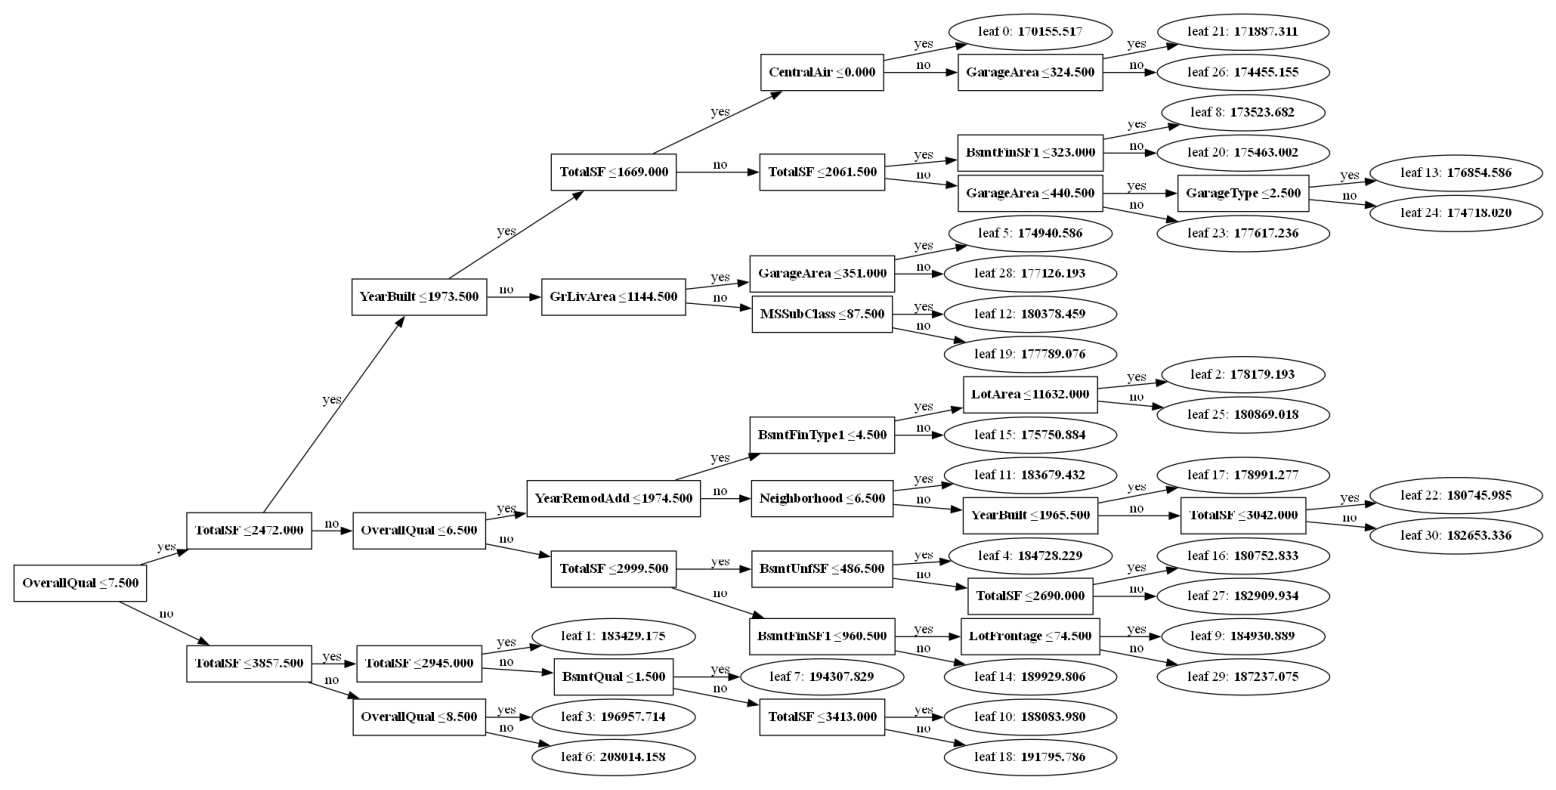

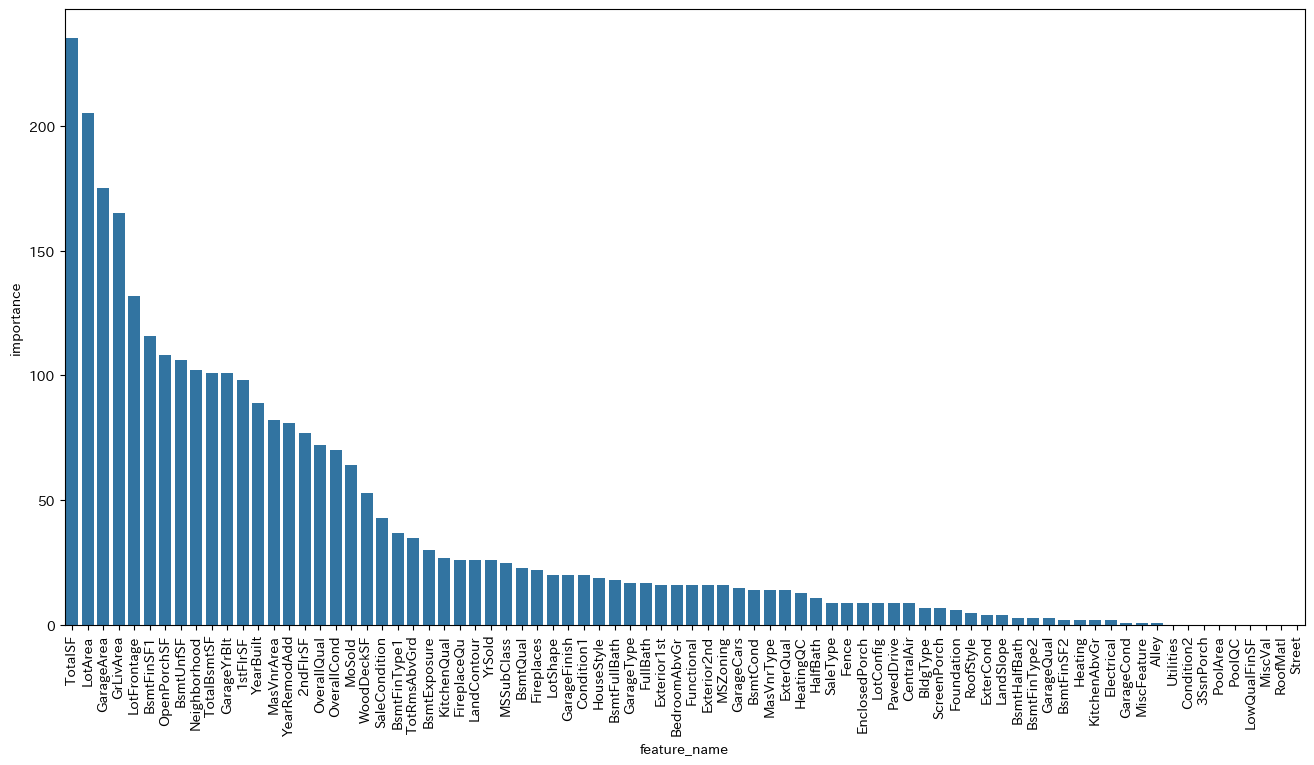

In [11]:
# 学習結果の図示(ここで表示しているのはクロスバリデーションの最後の分割時のモデルについて)
tree_idx = 0
print(f"{tree_idx + 1}番目の木の様子は以下の通り")


plot_tree(model, tree_index=tree_idx, figsize=(20, 10))

# 特徴量重要度
df_feature_importances = pd.DataFrame(
    {"feature_name": model.feature_name_, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(data=df_feature_importances, x="feature_name", y="importance")
plt.xticks(rotation=90)
plt.show()

In [12]:
# 一度このまま提出用のデータを出力
model = LGBMRegressor(max_depth=-1)
model.fit(X, y)
sub_pred = model.predict(df_test)
submission = pd.DataFrame({"Id": df_test_Id, "SalePrice": sub_pred})
submission.to_csv(r"train_test_submission\submission.csv", index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3646
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 75
[LightGBM] [Info] Start training from score 180921.195890
